<a href="https://colab.research.google.com/github/iAmEthanMai/chess-engine-model/blob/main/chess_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Python Chess Engine ♟️

**libraries**

---

In [ ]:
!pip3 install python-chess
!pip3 install cairosvg

In [2]:
import chess
import chess.svg
import cairosvg
from cairosvg import svg2png
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import tensorflow as tf
from IPython.display import clear_output

**import the model**

---

In [16]:
!git clone https://github.com/iAmEthanMai/chess-engine-model.git

Cloning into 'chess-engine-model'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 15 (delta 4), reused 15 (delta 4), pack-reused 0
Unpacking objects: 100% (15/15), done.


**model utils**

---

In [17]:
path_to_model = '/content/chess-engine-model'

global model
model = tf.saved_model.load(path_to_model)

In [4]:
def predict(df_eval, imported_model):
    """Return array of predictions for each row of df_eval
    
    Keyword arguments:
    df_eval -- pd.DataFrame
    imported_model -- tf.saved_model 
    """
    col_names = df_eval.columns
    dtypes = df_eval.dtypes
    predictions = []
    for row in df_eval.iterrows():
        example = tf.train.Example()
        for i in range(len(col_names)):
            dtype = dtypes[i]
            col_name = col_names[i]
            value = row[1][col_name]
            if dtype == "object":
                value = bytes(value, "utf-8")
                example.features.feature[col_name].bytes_list.value.extend([value])
            elif dtype == "float":
                example.features.feature[col_name].float_list.value.extend([value])
            elif dtype == "int":
                example.features.feature[col_name].int64_list.value.extend([value])
        predictions.append(imported_model.signatures["predict"](examples = tf.constant([example.SerializeToString()])))

    return predictions

In [5]:
def get_board_features(board):
    """Return array of features for a board
    
    Keyword arguments:
    board -- chess.Board()
    """
    board_features = []
    for square in chess.SQUARES:
        board_features.append(str(board.piece_at(square)))
    return board_features

In [6]:
def get_move_features(move):
    """Return 2 arrays of features for a move
    
    Keyword arguments:
    move -- chess.Move
    """
    from_ = np.zeros(64)
    to_ = np.zeros(64)
    from_[move.from_square] = 1
    to_[move.to_square] = 1
    return from_, to_

In [7]:
def get_possible_moves_data(current_board):
    """Return pd.DataFrame of all possible moves used for predictions
    
    Keyword arguments:
    current_board -- chess.Board()
    """
    data = []
    moves = list(current_board.legal_moves)
    for move in moves:
        from_square, to_square = get_move_features(move)
        row = np.concatenate((get_board_features(current_board), from_square, to_square))
        data.append(row)
    
    board_feature_names = chess.SQUARE_NAMES
    move_from_feature_names = ['from_' + square for square in chess.SQUARE_NAMES]
    move_to_feature_names = ['to_' + square for square in chess.SQUARE_NAMES]
    
    columns = board_feature_names + move_from_feature_names + move_to_feature_names
    
    df = pd.DataFrame(data = data, columns = columns)
    
    for column in move_from_feature_names:
      df[column] = df[column].astype(float)
    for column in move_to_feature_names:
      df[column] = df[column].astype(float)

    return df

In [8]:
def find_best_move(current_board, model):
    """Return the best chess.Move
    
    Keyword arguments:
    current_board -- chess.Board()
    model -- tf.saved_model
    """
    moves = list(current_board.legal_moves)
    df_eval = get_possible_moves_data(current_board)
    predictions = predict(df_eval, model)
    good_move_probas = []
    for prediction in predictions:
        proba = str(prediction['probabilities'].numpy()[0])
        try:
          proba = float(proba.replace('[','').replace(']','').split(' ')[1])
          good_move_probas.append(proba)
        except:
          good_move_probas.append(0.0)
    dict_ = dict(zip(moves, good_move_probas))
    return max(dict_, key=dict_.get)

**game utils**

---

In [9]:
def draw_board(current_board):
  """Draw board

   Keyword arguments:
   current_board -- chess.Board()
  """
  board_img = chess.svg.board(current_board)
  svg2png(bytestring=board_img,write_to='/content/board.png')
  img = mpimg.imread('/content/board.png')
  imgplot = plt.imshow(img)
  plt.show()

def save_board_img(current_board):
  board_img = chess.svg.board(current_board)
  svg2png(bytestring=board_img,write_to='/content/board.png')
  img = mpimg.imread('/content/board.png')

In [10]:
def can_checkmate(move, current_board):
  """Return True if a move can checkmate
    
  Keyword arguments:
  move -- chess.Move
  current_board -- chess.Board()
  """
  fen = current_board.fen()
  future_board = chess.Board(fen)
  future_board.push(move)
  return future_board.is_checkmate()

In [11]:
def ai_play_turn(current_board):
  """Handdle the A.I's turn

  Keyword arguments:
  current_board -- chess.Board()
  """
  for move in current_board.legal_moves:
    if(can_checkmate(move, current_board)):
      current_board.push(move)
      return
    
  best_move = find_best_move(current_board, model)
  current_board.push(best_move)
  return

In [12]:
def human_play_turn(current_board):
  """Handle the human's turn

  Keyword arguments:
  current_board = chess.Board()
  """
  clear_output()
  #draw_board(current_board)
  save_board_img(current_board)
  print(current_board)
  move_uci = input('Enter your move: ')

  try: 
      move = chess.Move.from_uci(move_uci)
  except:
      return human_play_turn(current_board) 
  if(move not in current_board.legal_moves):
      return human_play_turn(current_board)
  current_board.push(move)
  return

In [13]:
def play_game(turn, current_board):
  """Play through the whole game
    
  Keyword arguments:
  turn -- True for A.I plays first
  current_board -- chess.Board()
  """
  if(not turn):
     if(not current_board.is_checkmate()):
         human_play_turn(current_board)
         return play_game(not turn, current_board)
     else:
         print('A.I wins')
         return
  else:
     if(not current_board.is_checkmate()):
         ai_play_turn(current_board)
         return play_game(not turn, current_board)
     else:
         print('Human wins')
         return

In [14]:
def play():
  """Init and start the game
  """
  board = chess.Board()
  human_first = input('Care to start? [y/n]: ')
  clear_output()
  if(human_first == 'y'):
     return play_game(False, board)
  else:
     return play_game(True, board)

**play**

---

In [ ]:
play()

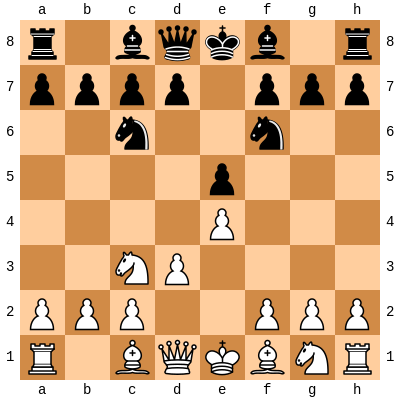

In [20]:
import PIL.Image
PIL.Image.open('/content/board.png')